
# Part B – Model 1: Classical ML Sentiment Classifier (TF–IDF)

This notebook:
- Loads TF–IDF features and labels.
- Trains a classical ML model (Logistic Regression / SVM / Naive Bayes).
- Evaluates performance: F1-score, confusion matrix, ROC & PR curves.
- Collects misclassified examples.
- Saves predictions and probabilities for use in the RL selector.


In [1]:

import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

print("Processed data directory:", PROCESSED_DIR.resolve())


Processed data directory: C:\Users\Dell\Desktop\Group_2\imdb_sentiment_project\data\processed



## 1. Load Processed Data (TF–IDF and Labels)


In [2]:

# Load data
X_tfidf = sparse.load_npz(PROCESSED_DIR / "X_tfidf.npz")
labels = np.load(PROCESSED_DIR / "labels.npy")
full_df = pd.read_csv(PROCESSED_DIR / "full_df_clean.csv")

print("TF-IDF shape:", X_tfidf.shape)
print("Labels shape:", labels.shape)


TF-IDF shape: (50000, 20000)
Labels shape: (50000,)



## 2. Train/Test Split

Use a simple train/test split (or use the original IMDb train/test split if you prefer).


In [3]:

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_tfidf, labels, full_df, test_size=0.25, random_state=42, stratify=labels
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 37500
Test size: 12500



## 3. Train Classical ML Model

Choose ONE: Logistic Regression / SVM / Naive Bayes.
Below is an example with Logistic Regression; you may replace it.


In [4]:

# Example: Logistic Regression classifier
clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


F1-score: 0.8936203894253602
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6250
           1       0.88      0.90      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500




## 4. Confusion Matrix


In [5]:

cm = confusion_matrix(y_test, y_pred)
cm


array([[5511,  739],
       [ 605, 5645]])

In [ ]:

fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title("Confusion Matrix – Classical ML")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()



## 5. ROC and Precision–Recall Curves


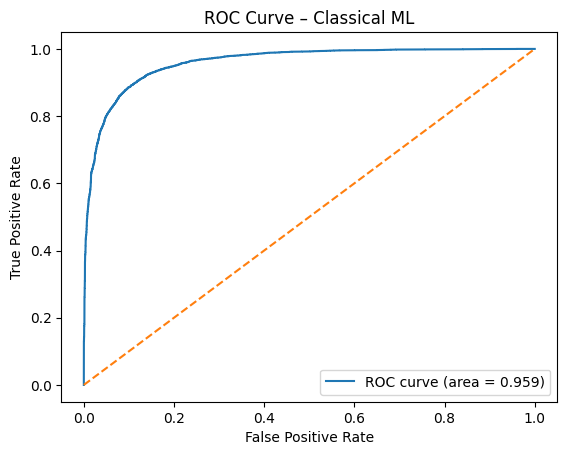

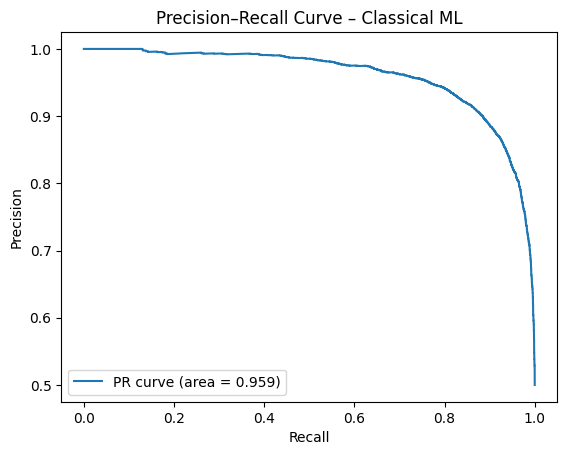

In [6]:

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Classical ML")
plt.legend()
plt.show()

# Precision–Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Classical ML")
plt.legend()
plt.show()



## 6. Misclassified Examples

Show 5 misclassified reviews with:
- True label
- Predicted label
- Model probability


In [7]:

mis_idx = np.where(y_pred != y_test)[0]
print("Total misclassified:", len(mis_idx))

for i in mis_idx[:5]:
    print("\n--- Misclassified Example ---")
    print("True label:", y_test[i])
    print("Predicted label:", y_pred[i])
    print("Predicted probability (positive):", float(y_proba[i]))
    print("Review:")
    print(df_test.iloc[i]["review"][:700], "...")


Total misclassified: 1344

--- Misclassified Example ---
True label: 1
Predicted label: 0
Predicted probability (positive): 0.4589939328313505
Review:
I loved this film almost as much as the origional version!What teenager DOESN'T go through what Scamp's going through;wanting to find independence by getting more and more distant from your family?The songs were nice to,and the character designs were great.Lady and Tramp look almost exactly like they did in the origional feature.They did a good job on the voices of those two,too considering the fact that the origional voice actors are probably dead.However,I do think they should've given more lines to Lady,Annette,Colette,and Daniel.Oh well;at least they had the common sense to keep the same scenery from the original film. ...

--- Misclassified Example ---
True label: 0
Predicted label: 1
Predicted probability (positive): 0.6404754671870628
Review:
There's not really that much wrong with Crash of the Moons. Basically it's a few episodes


## 7. Save ML Predictions and Probabilities for RL

We will need ML predictions and probabilities for each review in the test set
when training the RL model selector.


In [8]:

ml_results = pd.DataFrame({
    "y_true": y_test,
    "y_pred_ml": y_pred,
    "p_ml": y_proba,
    "review": df_test["review"].values,
    "clean_review": df_test.get("clean_review", df_test["review"]).values
})

ml_results.to_csv(PROCESSED_DIR / "ml_results.csv", index=False)
print("Saved ML results to:", PROCESSED_DIR / "ml_results.csv")


Saved ML results to: ..\data\processed\ml_results.csv
